# Check tightness in synthetic data.

In [1]:
from collections import defaultdict
import networkx as nx
import numpy as np
from ot.gromov import gromov_wasserstein

from ogw.gromov_prox import projection_matrix
from ogw.gw_lb import flb, slb, tlb
from ogw.gwtil import eval_gwtil_lb, gwtil_lb, gwtil_ub
from ogw.utils import random_perturb
from torch_geometric.datasets import TUDataset
import os.path as osp
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# build path graph with structural noise
m, n = 20, 20
ROUND = 50
# connected graph
G1 = nx.path_graph(m)
A1 = nx.adjacency_matrix(G1).toarray()
# shortest path as cost matrix
C = nx.floyd_warshall_numpy(G1)

# uniform distribution
pc = np.ones(m) / m
pd = np.ones(n) / n


In [3]:
GWs = defaultdict(list)
GWs_flb = defaultdict(list)
GWs_slb = defaultdict(list)
GWs_tlb = defaultdict(list)

OGWs_lb = defaultdict(list)
OGWs_ub = defaultdict(list)

for budget in tqdm(range(1, 11), desc="Perturbation"):
    for r in range(ROUND):
        # random perturb graph
        A2 = random_perturb(A1, n=budget, seed=r)
        G2 = nx.from_numpy_array(A2)
        D = nx.floyd_warshall_numpy(G2)

        ''' gw '''
        T, gw_log = gromov_wasserstein(C, D, pc, pd, loss_fun="square_loss", log=True)

        # lower bounds of GW
        flb_dist = flb(C, D, p=2)
        slb_dist = slb(C, D, p=2)
        tlb_dist = tlb(C, D, p=2)

        ''' ogw '''
        ogw_ub_loss, P = gwtil_ub(C, D, return_matrix=True)
        ogw_lb_loss, Q1, Q2 = gwtil_lb(C, D, return_matrix=True)

        U = projection_matrix(m)
        V = projection_matrix(n)
        em = np.ones((m, 1))
        en = np.ones((n, 1))
        C_norm = np.linalg.norm(C)
        D_norm = np.linalg.norm(D)

        GWs[budget].append(gw_log['gw_dist'])
        GWs_flb[budget].append(flb_dist)
        GWs_slb[budget].append(slb_dist)
        GWs_tlb[budget].append(tlb_dist)
        OGWs_ub[budget].append(ogw_ub_loss)
        OGWs_lb[budget].append(ogw_lb_loss)


Perturbation: 100%|██████████| 10/10 [00:59<00:00,  5.97s/it]


Text(0.5, 0, '$\\delta_g$')

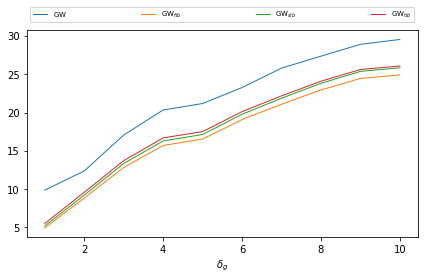

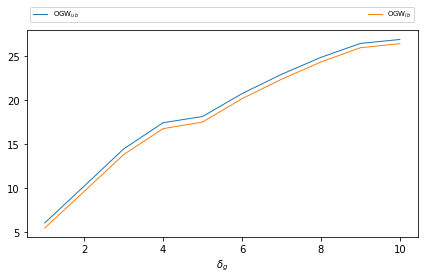

In [5]:
# Plot the figures
xs = list(GWs.keys())
GWs_avg = np.mean(list(GWs.values()), axis=1)
GWs_flb_avg = np.mean(list(GWs_flb.values()), axis=1)
GWs_slb_avg = np.mean(list(GWs_slb.values()), axis=1)
GWs_tlb_avg = np.mean(list(GWs_tlb.values()), axis=1)
OGWs_ub_avg = np.mean(list(OGWs_ub.values()), axis=1)
OGWs_lb_avg = np.mean(list(OGWs_lb.values()), axis=1)

fig = plt.figure( tight_layout=True)
plt.plot(xs, GWs_avg, label=r"$\mathsf{GW}$", linewidth=1)
plt.plot(xs, GWs_flb_avg, label=r"$\mathsf{GW}_{flb}$", linewidth=1)
plt.plot(xs, GWs_slb_avg, label=r"$\mathsf{GW}_{slb}$", linewidth=1)
plt.plot(xs, GWs_tlb_avg, label=r"$\mathsf{GW}_{tlb}$", linewidth=1)
plt.legend(loc="lower left", ncol=4,
           prop={'size': 7},
           bbox_to_anchor=(0., 1.02, 1., .2),
           mode="expand")
plt.xlabel(r"$\delta_g$")
# plt.savefig("gap_gw_flb_slb_tlb.pdf")

fig = plt.figure( tight_layout=True)
plt.plot(xs, OGWs_ub_avg, label=r"$\mathsf{OGW}_{ub}$", linewidth=1)
plt.plot(xs, OGWs_lb_avg, label=r"$\mathsf{OGW}_{lb}$", linewidth=1)
plt.legend(loc="lower left", ncol=2,
           prop={'size': 7},
           bbox_to_anchor=(0., 1.02, 1., .2),
           mode="expand")
plt.xlabel(r"$\delta_g$")
# plt.savefig("gap_ogw_ub_lb.pdf")
# plt.show()
